In [1]:
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
RANDOM_SEED = 27

In [3]:
df_orig = pd.read_csv('./winequalityN.csv')
df_orig.dropna(inplace=True)
# df_white = df[df.type=='white'].drop(columns='type')
# df_red = df[df.type=='white'].drop(columns='type')

* highly imbalanced

In [4]:
from sklearn.preprocessing import StandardScaler

## scorers

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

In [9]:
df = df_orig.copy()
df['type'] = df.type.map({'red': 1, 'white': 0})
df['quality'] = df['quality'].map({3:0, 4:0, 5:1, 6:2, 7:3, 8:4, 9:4})
x_train_val, x_test, y_train_val, y_test = train_test_split(df.drop(columns=['quality']),
                                                             df['quality'],
                                                             stratify=df['quality'],
                                                             test_size=0.2,
                                                             shuffle=True,
                                                             random_state=RANDOM_SEED )

In [6]:
(df.drop(columns='type') == 0).sum()

fixed acidity             0
volatile acidity          0
citric acid             150
residual sugar            0
chlorides                 0
free sulfur dioxide       0
total sulfur dioxide      0
density                   0
pH                        0
sulphates                 0
alcohol                   0
quality                   0
dtype: int64

In [50]:
import seaborn as sns
from matplotlib import pyplot as plt

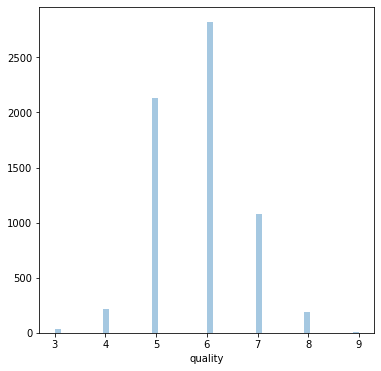

In [59]:
plt.figure(figsize=(6,6))
sns.distplot(df_orig.quality, kde=False)

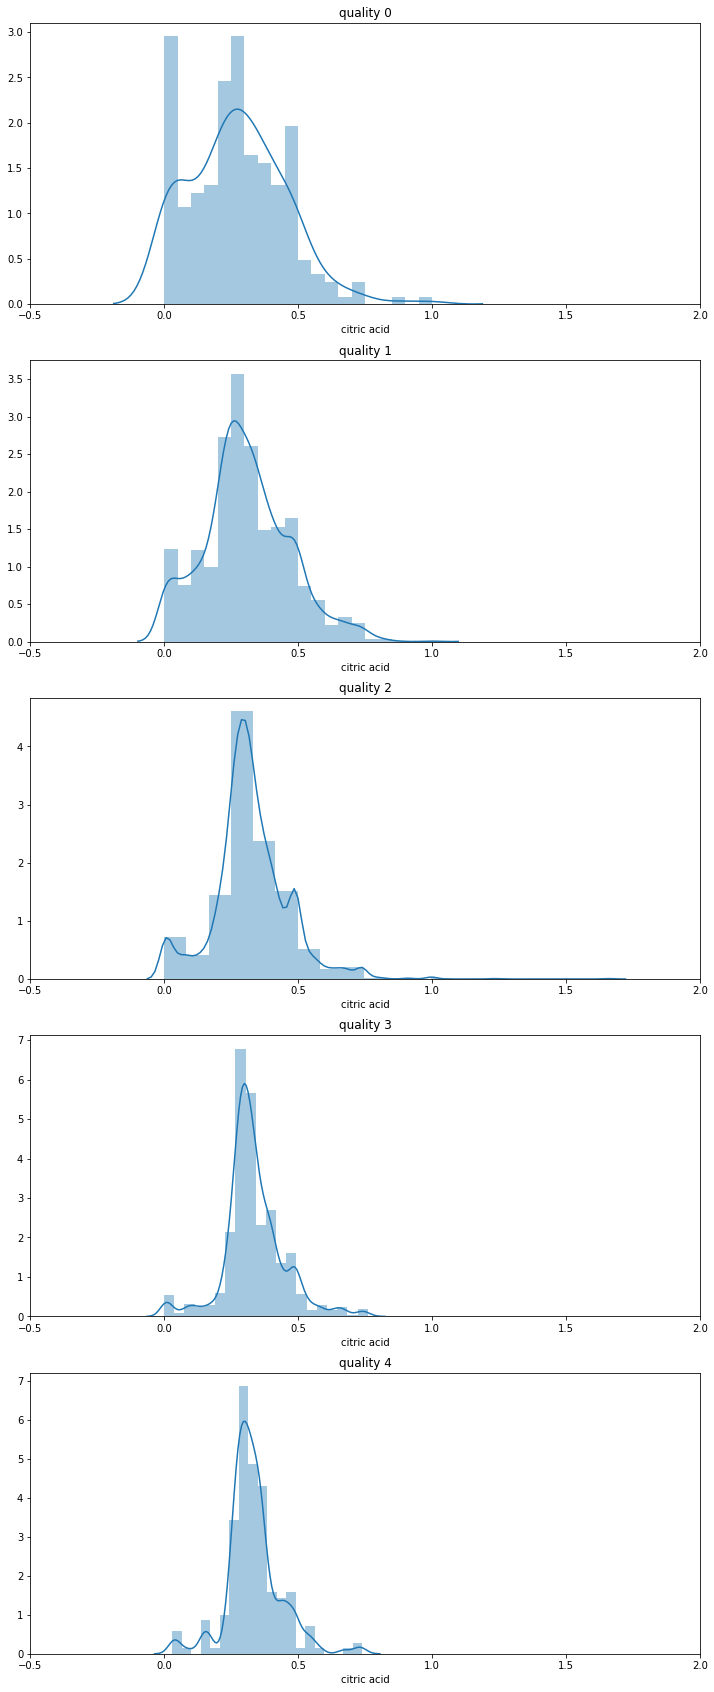

In [30]:
fig, axes = plt.subplots(nrows=df.quality.nunique(), ncols=1, figsize=(12,30))

for i, qual in enumerate(sorted(df.quality.unique())):
    ax=axes[i]
    dist = sns.distplot(df['citric acid'][df.quality==qual],
                        bins=20,
                        ax=ax)
    dist.set(xlim=(-.5, 2))
    ax.title.set_text('quality {}'.format(qual))


* we can notice that higher quality bigger mean of 'citric acid' let us check

In [33]:
df.groupby('quality').agg('mean')

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
quality,,,,,,,,,,,,
0,0.254098,7.351639,0.465328,0.273361,4.250000,0.061975,23.016393,106.100410,0.994933,3.235123,0.505902,10.181352
1,0.319549,7.329699,0.389774,0.307923,5.790602,0.064740,30.223919,120.715695,0.995847,3.212242,0.526184,9.838759
2,0.224823,7.180035,0.313598,0.323734,5.556454,0.054154,31.147163,115.385106,0.994560,3.217443,0.532365,10.588475
3,0.185289,7.131425,0.289055,0.334832,4.746182,0.045291,30.409683,108.370577,0.993130,3.227728,0.547058,11.389572
4,0.091371,6.853299,0.289315,0.333147,5.372081,0.040838,34.532995,117.695431,0.992504,3.224822,0.511929,11.685787


In [34]:
df.groupby('quality').agg('std')

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
quality,,,,,,,,,,,,
0,0.436248,1.336492,0.246559,0.180699,3.933634,0.049322,27.928512,69.540653,0.002540,0.190061,0.159883,1.001753
1,0.466411,1.261062,0.178656,0.160484,4.989145,0.042075,18.575271,60.799726,0.002442,0.157124,0.141829,0.815633
2,0.417540,1.293269,0.146946,0.142275,4.890080,0.030862,16.858228,55.467209,0.003040,0.160982,0.146731,1.126212
3,0.388713,1.374526,0.116852,0.111680,4.043956,0.021826,14.882852,47.897564,0.003025,0.159703,0.160774,1.199048
4,0.288869,1.146891,0.115441,0.101882,4.161541,0.015696,17.123059,41.688974,0.002881,0.156651,0.164656,1.274035


* notice that is is true also for 'free sulfur dioxide'

# try and check that using anova

In [49]:
import statsmodels.api as sm
from statsmodels.formula.api import ols



for col in df.columns:
    col_ = col.replace(' ', '_')
    df[col_] = df[col]

    mod = ols("{} ~ quality".format(col_),
                    data=df).fit()

    aov_table = sm.stats.anova_lm(mod, typ=2)
    print(col_, '==:', 'signif' if aov_table.loc['quality']['PR(>F)']<0.05 else 'not signif' )

type ==: signif
fixed_acidity ==: signif
volatile_acidity ==: signif
citric_acid ==: signif
residual_sugar ==: signif
chlorides ==: signif
free_sulfur_dioxide ==: signif
total_sulfur_dioxide ==: signif
density ==: signif
pH ==: not signif
sulphates ==: signif
alcohol ==: signif
quality ==: signif
citric_acid ==: signif
fixed_acidity ==: signif
volatile_acidity ==: signif
residual_sugar ==: signif
free_sulfur_dioxide ==: signif
total_sulfur_dioxide ==: signif


* almost all the features are should be usefull

# EDA

In [469]:
df_low = df_orig[df_orig.quality==0].drop(columns=['type', 'quality'])
df_mid = df_orig[df_orig.quality==1].drop(columns=['type', 'quality'])
df_high = df_orig[df_orig.quality==2].drop(columns=['type', 'quality'])

In [472]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_low.corr(), dtype=np.bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# correlation maps for different quality vines

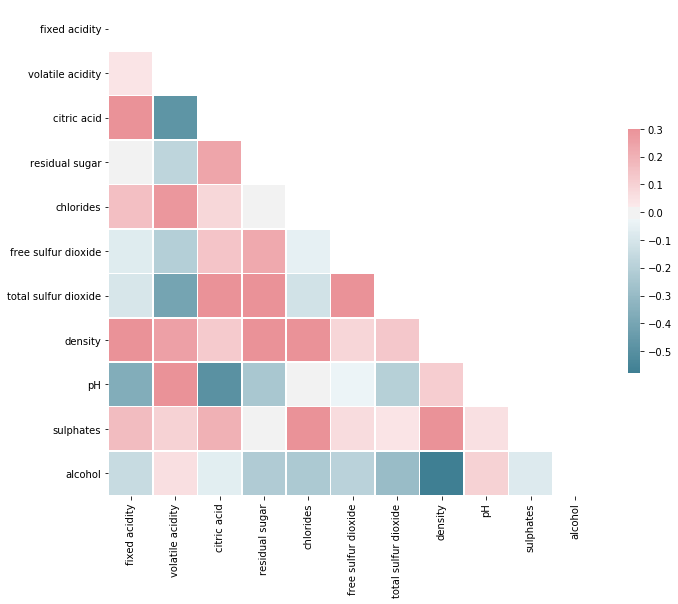

In [473]:
# Compute the correlation matrix
corr = df_low.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

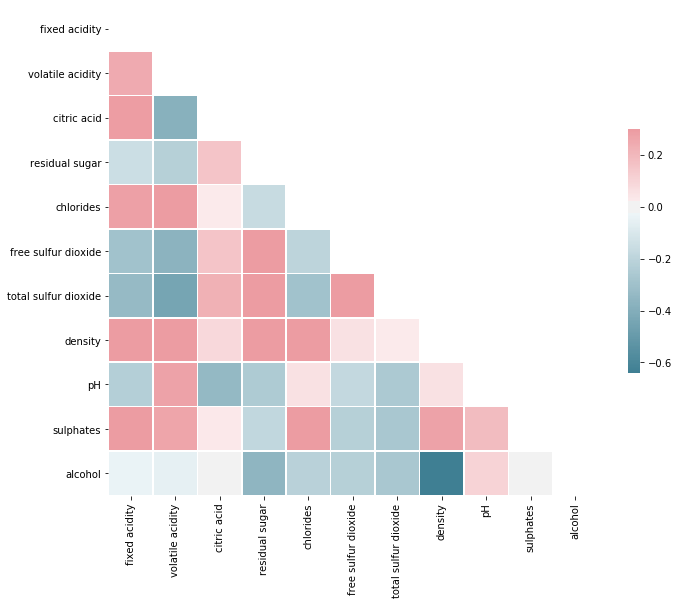

In [474]:
# Compute the correlation matrix
corr = df_mid.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

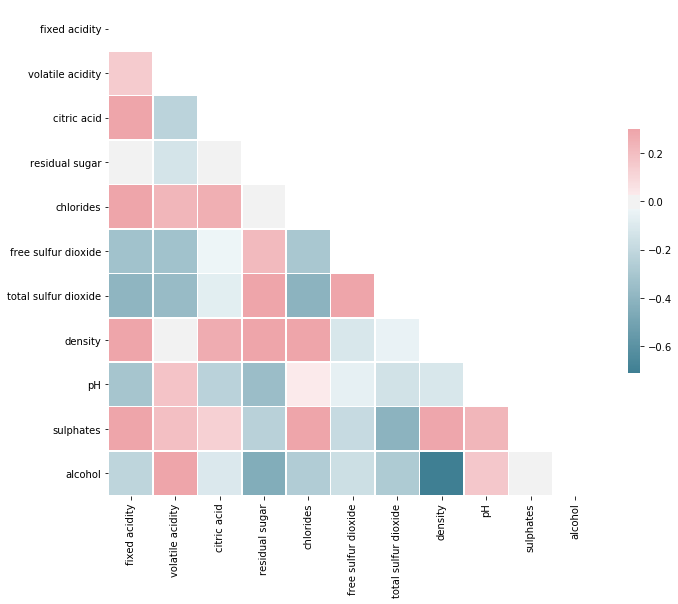

In [475]:
# Compute the correlation matrix
corr = df_high.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

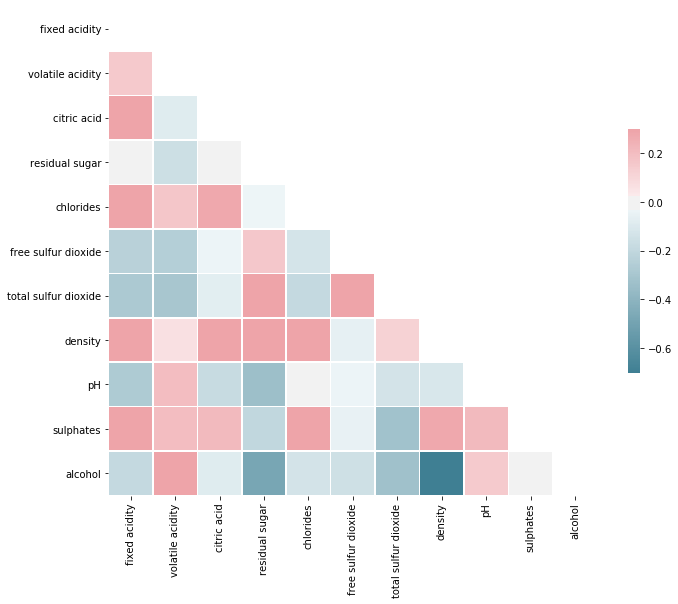

In [482]:
# Compute the correlation matrix
corr = (df_high*df_high).corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

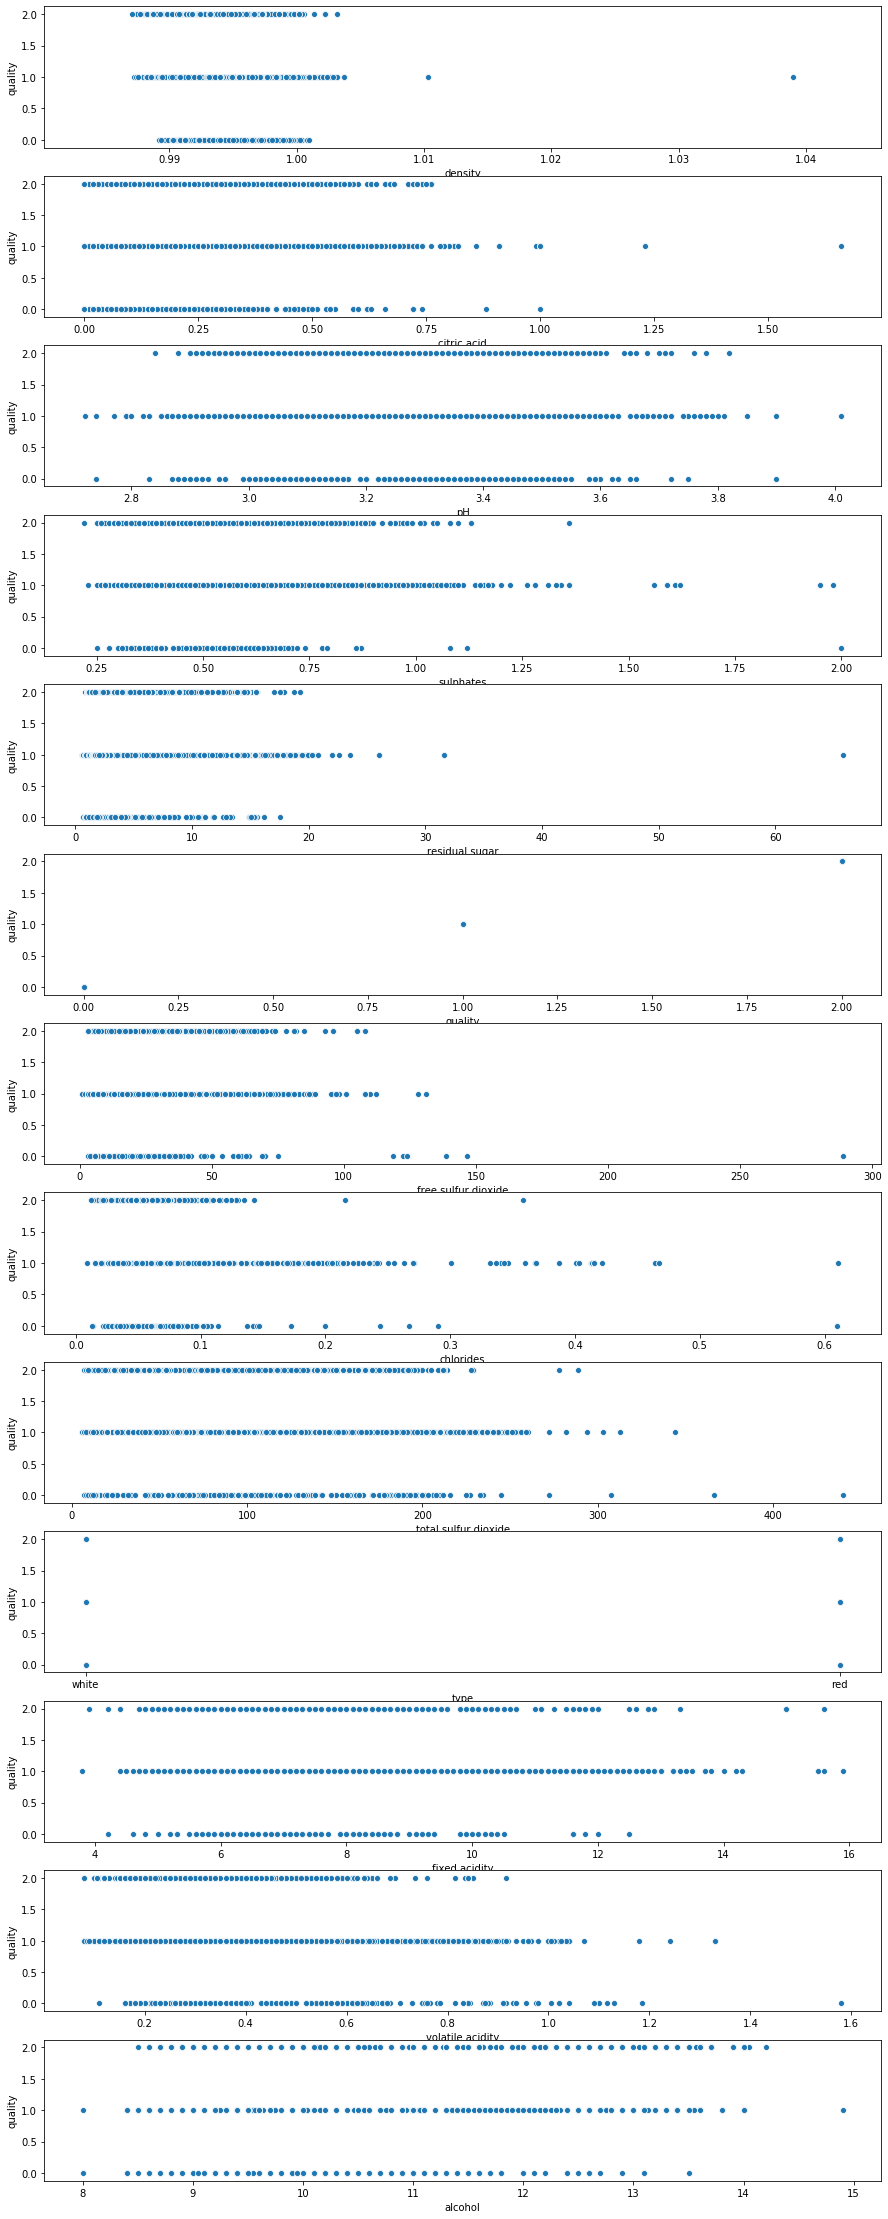

In [447]:
fig, axes = plt.subplots(nrows=len(feature_cols), ncols=1, figsize=(15,40))

feature_cols = set(df_orig.columns) - set('quality')
for i, col in enumerate(feature_cols):
    ax = axes[i]
#     ax.title.set_text(col)
    sns.scatterplot(data=df_orig, x=col, y='quality', ax=ax)


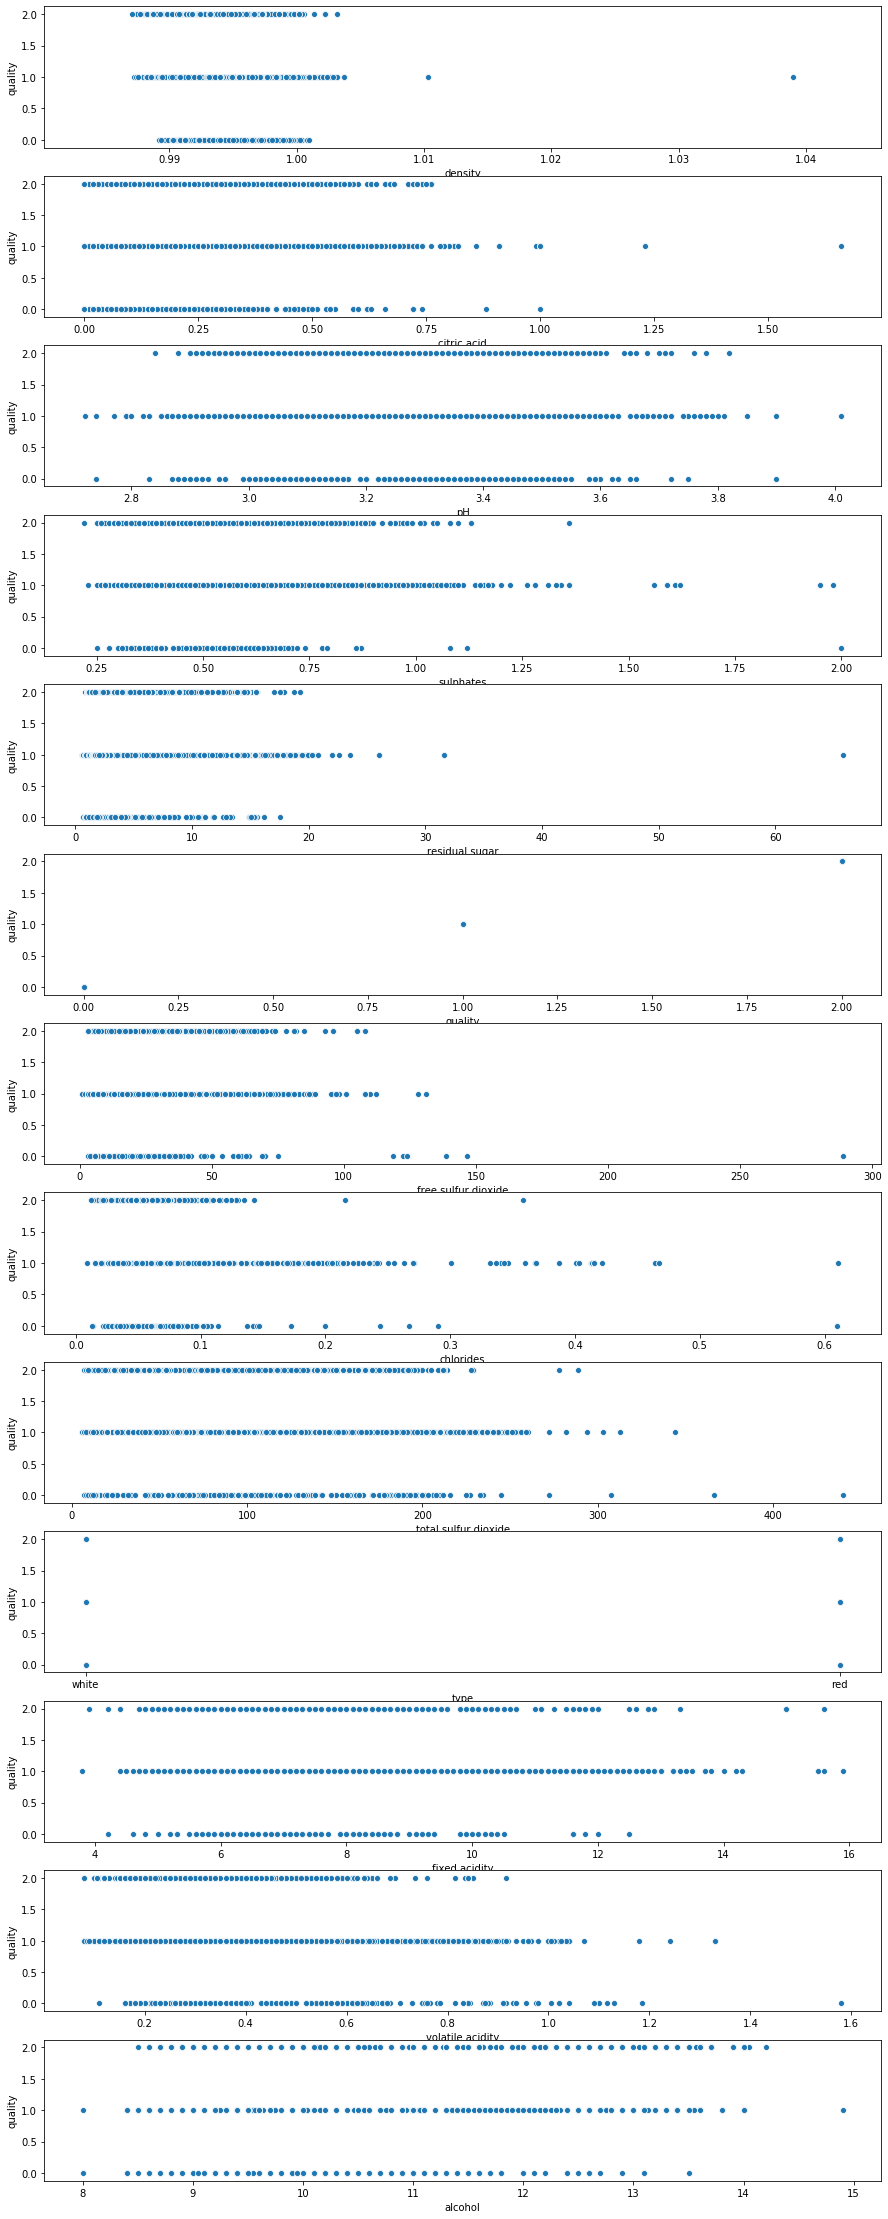

In [447]:
fig, axes = plt.subplots(nrows=len(feature_cols), ncols=1, figsize=(15,40))

feature_cols = set(df_orig.columns) - set('quality')
polinom
for i, col in enumerate(feature_cols):
    ax = axes[i]
#     ax.title.set_text(col)
    sns.scatterplot(data=df_orig, x=col, y='quality', ax=ax)


In [63]:
import featuretools as ft

In [64]:
data = pd.DataFrame(x_train_val, columns=df_orig.columns[:-1])
data['index'] = data.index
es = ft.EntitySet(id='asd')
es = es.entity_from_dataframe(
                              entity_id = 'wines',
                              dataframe = data,
                              index='index'
                             )

features_train, feature_names = ft.dfs(
                                 entityset=es,
                                 target_entity='wines', 
                                 max_depth = 2,
                                 verbose = 1, 
                                 n_jobs = -1,
                                 trans_primitives = ['multiply_numeric'],
                                )

Built 78 features
EntitySet scattered to 12 workers in 6 seconds                                                                         
Elapsed: 00:01 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [65]:
data = pd.DataFrame(x_test, columns=df_orig.columns[:-1])
data['index'] = data.index
es = ft.EntitySet(id='asd')
es = es.entity_from_dataframe(
                              entity_id = 'wines',
                              dataframe = data,
                              index='index'
                             )

features_test, feature_names = ft.dfs(
                                 entityset=es,
                                 target_entity='wines', 
                                 max_depth = 2,
                                 verbose = 1, 
                                 n_jobs = -1,
                                 trans_primitives = ['multiply_numeric'],
                                )

Built 78 features
EntitySet scattered to 12 workers in 5 seconds                                                                         
Elapsed: 00:01 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


# Logisitic Regression

In [22]:
from sklearn.linear_model import LogisticRegressionCV

In [29]:
res = []

ss = StandardScaler()
x_train_val = ss.fit_transform(features_train)
x_test = ss.transform(features_test)

class_weight = {label:(y_train_val==label).sum()/len(y_train_val) for label in y_train_val.unique()}
lr = LogisticRegressionCV(random_state=RANDOM_SEED,  
                          n_jobs=-1,
                          Cs=3,
                          cv = 5,
                          max_iter=500,
                          class_weight=class_weight,
                         )

lr.fit(x_train_val, y_train_val)

pred_train = lr.predict(x_train_val)
acc_train = (y_train_val == pred_train).sum() / len(y_train_val)
f1_train = f1_score(y_train_val, pred_train, average='weighted')
bal_acc_train = recall_score(y_train_val, pred_train, average='weighted')
res.append(['train', acc_train, f1_train, bal_acc_train, len(y_train_val)])

pred_test = lr.predict(x_test)
acc_test = (y_test == pred_test).sum() / len(y_test)
f1_test = f1_score(y_test, pred_test, average='weighted')
bal_acc_test = recall_score(y_test, pred_test, average='weighted')
res.append(['test', acc_test, f1_test, bal_acc_test, len(y_test)])

df_res = pd.DataFrame(res, columns = ['Eval', 'Acc', 'Rec', 'F1', 'Support'])
df_res

C:\Users\Hades\Anaconda3\envs\torch_cv\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Eval,Acc,Rec,F1,Support
0,train,0.548743,0.488808,0.548743,5170
1,test,0.527456,0.464367,0.527456,1293


In [30]:
pd.DataFrame(np.array(precision_recall_fscore_support(y_test, pred_test, average=None)).T,
             columns = ['Prec', 'Rec', 'F1', 'Support'])

,Prec,Rec,F1,Support
0,1.000000,0.061224,0.115385,49.0
1,0.639394,0.495305,0.558201,426.0
2,0.489926,0.819149,0.613139,564.0
3,0.375000,0.027907,0.051948,215.0
4,0.000000,0.000000,0.000000,39.0


# LightGBM

In [60]:
import lightgbm

In [61]:
np.random.seed(RANDOM_SEED)
features_train['weight'] = y_train_val.map(y_train_val.value_counts(normalize=True))
features_train['weight']
light_ds_train = lightgbm.Dataset(features_train, label=y_train_val, weight='weight')
features_train.drop(columns='weight', inplace=True)

NameError: name 'features_train' is not defined

In [878]:
parameters = {'application': 'multiclass',
              'boosting': 'gbdt',
              'num_class': y_train_val.nunique(),
              'metric': 'multi_error',
              'bagging_freq': 1,
              'bagging_fraction': 0.7,
              'feature_fraction': 0.5,
              'is_unbalance': 'true',
              'learning_rate': 0.1,
              'max_depth': 6,
              'num_leaves': 16,
              'is_unbalance': True,
              
#               'lambda_l2': 1,
#               'lambda_l1': 1,
              'max_bin': 16,
#               'min_data_in_leaf': 10,
             }

In [879]:
model = lightgbm.train(parameters,
                       light_ds_train,
                       num_boost_round=250,
#                        early_stopping_rounds=10,
                      )

res = []
pred_train = np.argmax(model.predict(features_train), axis=1)
acc_train = (y_train_val == pred_train).sum() / len(y_train_val)
f1_train = f1_score(y_train_val, pred_train, average='weighted')
bal_acc_train = recall_score(y_train_val, pred_train, average='weighted')
res.append(['train', acc_train, f1_train, bal_acc_train, len(y_train_val)])

pred_test = np.argmax(model.predict(features_test), axis=1)
acc_test = (y_test == pred_test).sum() / len(y_test)
f1_test = f1_score(y_test, pred_test, average='weighted')
bal_acc_test = recall_score(y_test, pred_test, average='weighted')
res.append(['test', acc_test, f1_test, bal_acc_test, len(y_test)])

df_res = pd.DataFrame(res, columns = ['Eval', 'Acc', 'Rec', 'F1', 'Support'])
df_res

,Eval,Acc,Rec,F1,Support
0,train,0.941199,0.941205,0.941199,5170
1,test,0.646558,0.638901,0.646558,1293


In [880]:
pd.DataFrame(np.array(precision_recall_fscore_support(y_test, pred_test, average=None)).T,
             columns = ['Prec', 'Rec', 'F1', 'Support'])

,Prec,Rec,F1,Support
0,0.571429,0.244898,0.342857,49.0
1,0.690745,0.718310,0.704258,426.0
2,0.622496,0.716312,0.666117,564.0
3,0.603659,0.460465,0.522427,215.0
4,0.937500,0.384615,0.545455,39.0


In [765]:
pd.DataFrame(np.array(precision_recall_fscore_support(y_test, pred_test, average=None)).T,
             columns = ['Prec', 'Rec', 'F1', 'Support'])

,Prec,Rec,F1,Support
0,0.500000,0.224490,0.309859,49.0
1,0.715935,0.727700,0.721769,426.0
2,0.642746,0.730496,0.683817,564.0
3,0.624309,0.525581,0.570707,215.0
4,0.937500,0.384615,0.545455,39.0


In [813]:
pd.DataFrame(np.array(precision_recall_fscore_support(y_test, pred_test, average=None)).T,
             columns = ['Prec', 'Rec', 'F1', 'Support'])

,Prec,Rec,F1,Support
0,0.500000,0.081633,0.140351,49.0
1,0.606715,0.593897,0.600237,426.0
2,0.507134,0.693262,0.585768,564.0
3,0.421053,0.186047,0.258065,215.0
4,0.000000,0.000000,0.000000,39.0


In [881]:
sorted(zip(model.feature_importance(), model.feature_name()), reverse=True)

[(424, 'Column_11'),
 (358, 'Column_53'),
 (339, 'Column_2'),
 (332, 'Column_42'),
 (306, 'Column_50'),
 (294, 'Column_30'),
 (291, 'Column_6'),
 (284, 'Column_22'),
 (279, 'Column_45'),
 (275, 'Column_10'),
 (273, 'Column_44'),
 (273, 'Column_19'),
 (272, 'Column_75'),
 (272, 'Column_52'),
 (269, 'Column_66'),
 (266, 'Column_21'),
 (264, 'Column_56'),
 (264, 'Column_35'),
 (259, 'Column_70'),
 (259, 'Column_40'),
 (259, 'Column_32'),
 (258, 'Column_48'),
 (258, 'Column_29'),
 (257, 'Column_18'),
 (256, 'Column_26'),
 (255, 'Column_58'),
 (254, 'Column_17'),
 (253, 'Column_16'),
 (252, 'Column_73'),
 (252, 'Column_12'),
 (251, 'Column_46'),
 (250, 'Column_20'),
 (249, 'Column_1'),
 (248, 'Column_4'),
 (248, 'Column_15'),
 (246, 'Column_65'),
 (245, 'Column_9'),
 (242, 'Column_72'),
 (242, 'Column_24'),
 (241, 'Column_71'),
 (241, 'Column_31'),
 (240, 'Column_62'),
 (236, 'Column_59'),
 (236, 'Column_55'),
 (232, 'Column_25'),
 (231, 'Column_3'),
 (231, 'Column_28'),
 (231, 'Column_14')

In [44]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [56]:
param_space = {
    'train_ds': light_ds_train,
    'num_boost_round': hp.choice('num_boost_round', range(150, 400, 50)),
    'application': 'multiclass',
    'metric': 'multi_error',
    'num_class': y_train_val.nunique(),
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': hp.choice('num_leaves', range(10, 20, 2)),
    'max_depth': hp.uniformint('max_depth', 4, 10),
    'feature_fraction': hp.choice('feature_fraction', range(60, 95, 5)) / 100,
    'bagging_fraction': hp.choice('bagging_fraction', range(60, 95, 5)) / 100,
    'bagging_freq': hp.uniformint('bagging_freq', 1, 3),
    'learning_rate': hp.choice('learning_rate', range(1, 75, 2)) / 100,
    'lambda_l2': hp.choice('lambda_l2', [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]),
    'lambda_l1': hp.choice('lambda_l1', [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]),
}

In [ ]:
def error_rate(params):
    cv_results = lightgbm.cv(
                            params={key:params[key] for key in params.keys()
                                    if key not in ['train_ds', 'num_boost_round']},
                            train_set=params['train_ds'],
                            num_boost_round=params['num_boost_round'],
                            nfold=5,
                            )
    print(params)
    print(cv_results['multi_error-mean'][-1])
    print('==========================')
    
    return {'loss': cv_results['multi_error-mean'][-1],
            'status': STATUS_OK
           }


trials = Trials()
best = fmin(fn=error_rate,
            space=param_space,
            algo=tpe.suggest,
            max_evals=500,
            trials=trials,
            rstate=np.random,
           )
    
print('best:', best)
print('trials:')
res = pd.DataFrame([(1-trial['result']['loss'], trial['misc']['vals']) for trial in trials],
                  columns=['accuracy', 'params'])

res_best = res.sort_values('accuracy', ascending=False)
res_best.iloc[:10]

{'application': 'multiclass', 'bagging_fraction': 0.8, 'bagging_freq': 2, 'boosting': 'gbdt', 'feature_fraction': 0.85, 'is_unbalance': 'true', 'lambda_l1': 10, 'lambda_l2': 3, 'learning_rate': 0.71, 'max_depth': 4, 'metric': 'multi_error', 'num_boost_round': 250, 'num_class': 5, 'num_leaves': 18, 'train_ds': <lightgbm.basic.Dataset object at 0x00000208218508B0>}
0.3940038684719536                                                                                                     
{'application': 'multiclass', 'bagging_fraction': 0.75, 'bagging_freq': 1, 'boosting': 'gbdt', 'feature_fraction': 0.65, 'is_unbalance': 'true', 'lambda_l1': 3, 'lambda_l2': 30, 'learning_rate': 0.61, 'max_depth': 8, 'metric': 'multi_error', 'num_boost_round': 200, 'num_class': 5, 'num_leaves': 10, 'train_ds': <lightgbm.basic.Dataset object at 0x00000208218508B0>}
0.3773694390715667                                                                                                     
{'application': 'multiclass

0.3551257253384913                                                                                                     
{'application': 'multiclass', 'bagging_fraction': 0.8, 'bagging_freq': 2, 'boosting': 'gbdt', 'feature_fraction': 0.85, 'is_unbalance': 'true', 'lambda_l1': 0.3, 'lambda_l2': 30, 'learning_rate': 0.37, 'max_depth': 7, 'metric': 'multi_error', 'num_boost_round': 200, 'num_class': 5, 'num_leaves': 14, 'train_ds': <lightgbm.basic.Dataset object at 0x00000208218508B0>}
0.3630560928433269                                                                                                     
{'application': 'multiclass', 'bagging_fraction': 0.7, 'bagging_freq': 2, 'boosting': 'gbdt', 'feature_fraction': 0.8, 'is_unbalance': 'true', 'lambda_l1': 1, 'lambda_l2': 1, 'learning_rate': 0.71, 'max_depth': 7, 'metric': 'multi_error', 'num_boost_round': 300, 'num_class': 5, 'num_leaves': 14, 'train_ds': <lightgbm.basic.Dataset object at 0x00000208218508B0>}
0.36054158607350095         

In [ ]:
res_best.iloc[0].params

In [ ]:
parameters = {'application': 'multiclass',
              'boosting': 'gbdt',
              'num_class': y_train_val.nunique(),
              'metric': ['multi_error'],
              'bagging_freq': 1,
              'bagging_fraction': 0.9,
              'feature_fraction': 0.9,
              'is_unbalance': 'true',
              'learning_rate': 0.3,
              'max_depth': 5,
              'num_leaves': 20,
              'lambda_l2': 0.1,
              'lambda_l1': 0.1,
#               'weight': 'weight'
             }

In [55]:
cv_results = lightgbm.cv(
                        params=parameters,
                        train_set=light_ds_train,
                        num_boost_round=250,
                        nfold=5,
                        )

print(1-cv_results['multi_error-mean'][-1])

LightGBMError: Check failed: max_bin >1 at C:\Users\VssAdministrator\AppData\Local\Temp\pip-req-build-fedrb21_\compile\src\io\config_auto.cpp, line 433 .


In [850]:
cv_results = lightgbm.cv(
                        params=parameters,
                        train_set=light_ds_train,
                        num_boost_round=250,
                        nfold=5,
                        )

print(1-cv_results['multi_error-mean'][-1])

0.6481624758220503
